In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import string
from nltk.corpus import stopwords
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Question #1

#### Path to tweet dataset

In [2]:
path_to_file = r"gender-classifier-DFE-791531.csv"

In [3]:
loaded_tweets = pd.read_csv(path_to_file, encoding='latin-1')

genders = {'female', 'male', 'brand'}
clean_loaded_tweets = loaded_tweets.loc[loaded_tweets['gender'].isin(genders)]

clean_loaded_tweets.loc[loaded_tweets['text'].isnull(), 'text'] = "-"
clean_loaded_tweets.loc[loaded_tweets['description'].isnull(), 'description'] = "-"

tweets = clean_loaded_tweets["text"].map(str) + " " + clean_loaded_tweets["description"]

#### Loaded Tweets by Gender

In [4]:
print(loaded_tweets["gender"].value_counts())

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64


#### Cleaned Tweets by Gender

In [5]:
print(clean_loaded_tweets["gender"].value_counts())

female    6700
male      6194
brand     5942
Name: gender, dtype: int64


### Class Distribution

Tweet Distribution By Gender


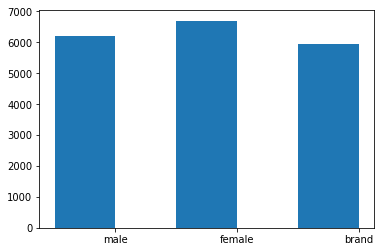

In [6]:
gender_column = clean_loaded_tweets["gender"]
counter = Counter(gender_column)
genders = counter.keys()
tweet_amount = counter.values()
indexes = np.arange(len(genders))

plt.bar(indexes, tweet_amount, 0.5)
plt.xticks(indexes + 0.5 * 0.5, genders)
print('Tweet Distribution By Gender')
plt.show()

## Text Pre-Processing

In [7]:
punctuation = list(string.punctuation)
stop_words = set(stopwords.words('english') + punctuation + list("__"))

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)


def clean_and_tokenize(text):
    tokenized_clean_text = []
    text = re.sub(r'[^\x00-\x7f]*', r'', text)
    tokens = tokens_re.findall(text)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    for token in tokens:
        if token in stop_words:
            continue
        tokenized_clean_text.append(token)
    return tokenized_clean_text

#### Tokenizing cleaned tweets

In [8]:
tokenized_tweets = []
for tweet in tweets:
    if isinstance(tweet, str):
        tokenized_tweet = clean_and_tokenize(tweet)
        tokenized_tweets.append(tokenized_tweet)

In [9]:
def get_gender_most_common_terms(terms,top):
    res = []
    counter = Counter()
    for term in terms:
        res.extend([token for token in clean_and_tokenize(term)])
    counter.update(res)
    return counter.most_common(top)

#### Get most common terms by gender

In [10]:
top_amount = 50

for gender in genders:
    gender_most_common_terms=get_gender_most_common_terms(
        loaded_tweets.loc[loaded_tweets['gender'] == gender]['text'],
        top_amount)
    
    gender_most_common_terms=pd.DataFrame(gender_most_common_terms, columns=['Term', 'Count'])
    print(str.upper(gender[0])+ gender[1:]+ ' Most Common Terms\n')
    print(gender_most_common_terms)
    print("\n"+'-'*30 + "\n")


Male Most Common Terms

      Term  Count
0     like    352
1      get    346
2      one    267
3     time    232
4      new    216
5     love    209
6       go    205
7   people    197
8     good    186
9      day    186
10    know    184
11     see    168
12     got    159
13       2    159
14    back    157
15   think    157
16   would    154
17    best    152
18     amp    152
19    make    149
20   still    144
21    last    144
22      __    137
23    need    136
24    want    135
25       1    120
26     way    118
27  really    117
28   great    116
29     lol    113
30    game    113
31    year    110
32    well    109
33     via    108
34   going    108
35       u    107
36   world    103
37      im    102
38    much    102
39   first    101
40   today    101
41     man     99
42  always     98
43    come     97
44     let     95
45    even     94
46    life     94
47       3     93
48    shit     93
49   could     91

------------------------------

Female Most Common Terms


# Question #2

In [11]:
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import json
import keras.preprocessing.text as kerasPreprocessing
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


In [12]:
text_list=[''.join([token + " " for token in tweet]) 
           for tweet in tokenized_tweets]

test_ratio=0.2

X_train, X_test, y_train, y_test = train_test_split(text_list, 
                                                    gender_column, 
                                                    test_size=test_ratio, 
                                                    shuffle=False)

### TF-IDF Vectorizer

For our models we've chosen Keras, SVN and K-Nearest Neighbors which all use the TF-IDF Vectorizer. For this reason, we're saving the most common words in a dictionary to refer to when converting from text and/or description from the tweets.

In [13]:
tf_idf_vectorizer = TfidfVectorizer()
X_train_vectorized = tf_idf_vectorizer.fit_transform(X_train)
X_test_vectorized = tf_idf_vectorizer.transform(X_test)

term_cap = 5000
tokenizer = Tokenizer(num_words=term_cap)
tokenizer.fit_on_texts(text_list)
term_dictionary= tokenizer.word_index

In [14]:
def words_to_indices(txt):
    return [term_dictionary[word] 
            for word in kerasPreprocessing.text_to_word_sequence(txt)]

In [15]:
words_to_indices_train = [words_to_indices(text) for text in X_train]
words_to_indices_train = np.asarray(words_to_indices_train)

words_to_indices_test=[words_to_indices(text) for text in X_test]
words_to_indices_test = np.asarray(words_to_indices_test)

## Keras

We're using the Sequential model whih is a linear stack of layers.
for more information: https://keras.io/getting-started/sequential-model-guide/

### Creating the Model

#### To prevent overfitting, we're using Dropout on hidden layers
For more information, please refer to this article:
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [16]:
model = Sequential([
    Dense(1024, input_shape=(term_cap,), name='layer_1'),
    Activation('relu'),
    Dropout(0.5, name='layer_2'),
    Dense(512, name='layer_3'),
    Activation('sigmoid'),
    Dropout(0.5, name='layer_4'),
    Dense(len(genders), name='layer_5'),
    Activation('softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Data Preperation

In [17]:
X_train_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_train, mode='binary')
X_test_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_test, mode='binary')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

y_train_categorical_matrix = keras.utils.to_categorical(y_train_encoded, 3)
y_test_categorical_matrix = keras.utils.to_categorical(y_test_encoded, 3)

#### Training Keras

In [18]:
print("Training Keras")
print('-'*20)

batch = 256
num_iterations = 2
visible = 1

model.fit(X_train_tokenized_matrix, y_train_categorical_matrix,
  batch_size = batch,
  epochs = num_iterations,
  verbose = visible,
  validation_data = (X_test_tokenized_matrix, y_test_categorical_matrix), shuffle = True)

print("Training Complete")

Training Keras
--------------------
Instructions for updating:
Use tf.cast instead.
Train on 15068 samples, validate on 3768 samples
Epoch 1/2
15068/15068 [==============================] - 18s 1ms/step - loss: 1.0037 - acc: 0.4995 - val_loss: 0.8775 - val_acc: 0.5982
Epoch 2/2
15068/15068 [==============================] - 17s 1ms/step - loss: 0.7012 - acc: 0.6848 - val_loss: 0.8983 - val_acc: 0.6096
Training Complete


#### Testing Keras

In [19]:
print("Testing Keras")
scores = model.evaluate(X_test_tokenized_matrix, y_test_categorical_matrix, verbose = 1)

Testing Keras
3768/3768 [==============================] - 2s 498us/step


In [20]:
print("Params: batch_size = "+str(batch)+"\tepochs = "+str(num_iterations))
print("Model Accuracy %.2f%%" % (scores[1]*100))

Params: batch_size = 256	epochs = 2
Model Accuracy 60.96%


#### SVN and K-Nearest Neighbors

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn import metrics

#### Classifier train and test function

In [22]:
def test_classifier(classifier,classifier_name, X_train, X_test):
    #Train
    print("Training "+classifier_name)
    print('-'*20)
    classifier.fit(X_train, y_train)

    #Test 
    print("Testing "+classifier_name)
    pred = classifier.predict(X_test)

    #Accuracy Evaluation
    accuracy = metrics.accuracy_score(y_test, pred)

    print("Accuracy: %.2f%%" % (accuracy*100))
    print()

In [23]:
results_tfidf = []
classifiers = [(SGDClassifier(), "SVM"),(KNeighborsClassifier(), "K-Nearest Neighbors")]

for classifier, classifier_name in classifiers:
    test_classifier(classifier,classifier_name, X_train_vectorized, X_test_vectorized)

Training SVM
--------------------
Testing SVM
Accuracy: 60.30%

Training K-Nearest Neighbors
--------------------
Testing K-Nearest Neighbors
Accuracy: 49.76%



# Question #3

#### Find most common country - US & Canada

In [24]:
tweet_location_train, tweet_location_test = train_test_split(clean_loaded_tweets["user_timezone"], 
                                                           test_size=0.30, 
                                                           shuffle = False)
tweet_location_train = tweet_location_train.dropna()

counter = Counter()
counter.update(tweet_location_train)
print(counter.most_common(1))

[('Eastern Time (US & Canada)', 1667)]


### Twitter Mining

In [25]:
import tweepy
from tweepy import OAuthHandler

## OAuth

In [26]:
def authenticate(consumer_key,
                 consumer_secret, 
                 access_token, 
                 access_secret):
    
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return tweepy.API(auth, wait_on_rate_limit = True)

In [27]:
api = authenticate('xGmH3k9cREZ4hpnjsYQtIQ5um',
                  '25bBLLue9d9LT8RySWTTG4dwvn0iEbymwpvgfvUtsopghkLVrL',
                  '2827486724-433UvU84r38VPaAbmqyzT95MvjHUIcB25NUZYQ7',
                  'GuGv8nwmVEv8u3ItlpYNwxoO5HOzAseic6RlgETXffd71')


In [28]:
tweets_file_name = 'downloaded_tweets'

### Saves the tweeets to file by batch downloading

#### Define Custom StreamListener

In [29]:
class TweetStreamListener(tweepy.StreamListener):
    
    def __init__(self, api=None):
        super(TweetStreamListener, self).__init__()
        self.num_tweets = 0

    def on_data(self, data):
        if self.num_tweets < 15000:
                try:
                    with open(tweets_file_name+'.json', 'a') as tweet_file:
                        tweet_file.write(data)
                        self.num_tweets += 1
                        return True
                except BaseException as e:
                    print("Error on_data: " + str(e))
                    return True
        else:
            return False

    def on_error(self, status):
        print("Error: "+status)
        return True

#### Download live tweets with out custom StreamListener

In [30]:
tweet_listener = TweetStreamListener()
tweet_stream = tweepy.Stream(auth=api.auth, listener=tweet_listener)
tweet_stream.filter(locations=[-162.8,28.2,-64.4,71.6])

#### Read and pre-process tweets from file

In [31]:
with open(tweets_file_name + '.json') as tweet_file:
    proccessed_tweets = []
    for jsonStr in tweet_file:
        try:
            tweet = json.loads(jsonStr)
        except:
            continue
            
        tweet_text = tweet['text']
        tweet_id = tweet['id']
            
        cleaned_tweet_text = ""
        for token in clean_and_tokenize(tweet_text):
            cleaned_tweet_text += token + " "
            
        proccessed_tweets.append({'Tweet_ID': tweet_id, 'Tweet_Text': cleaned_tweet_text})

In [32]:
proccessed_tweets = pd.DataFrame(proccessed_tweets)

#### Get term count from downloaded tweets

In [33]:
data = get_gender_most_common_terms(proccessed_tweets['Tweet_Text'], top_amount)
term_df = pd.DataFrame(data, columns = ['Term','Count'])

print(term_df)

                Term  Count
0               like    820
1                job    704
2                day    603
3                 im    522
4                 st    456
5                see    443
6                get    414
7               time    388
8              happy    382
9                one    363
10             today    350
11              love    347
12                go    326
13             great    320
14              link    316
15               amp    314
16              dont    308
17             click    304
18               new    302
19              good    300
20               bio    297
21              want    276
22               got    269
23              work    261
24              know    253
25  @realdonaldtrump    238
26            people    236
27              back    231
28               lol    229
29             apply    227
30            latest    223
31                us    218
32            really    216
33              team    213
34                 2

#### Tokenize the terms

In [34]:
tokenizer = Tokenizer(num_words=term_cap)

## Question #4

#### Predict the gender of the downloaded tweets

In [ ]:
genders = ['brand', 'female', 'male']
prediction_df = []

for tweet_id in proccessed_tweets['Tweet_ID']:
    tweet_text = proccessed_tweets.loc[proccessed_tweets['Tweet_ID'] == tweet_id]['Tweet_Text']
    tweet_text = tweet_text.to_string()
    
    words = kerasPreprocessing.text_to_word_sequence(tweet_text)
    indices = []
    for term in words:
        if term in term_dictionary:
            indices.append(term_dictionary[term])
            
    model_matrix = tokenizer.sequences_to_matrix([indices], mode='binary')
    
    pred = model.predict(model_matrix)
    data = tweet_text + "," + str(genders[np.argmax(pred)]) + "," + str(pred[0][np.argmax(pred)] * 100) + '\n'
    pred_gender= str(genders[np.argmax(pred)])
    
    prediction_df.append([tweet_id,pred_gender])

In [ ]:
prediction_df=pd.DataFrame(prediction_df, columns = ['id', 'gender'])
prediction_df['gender'].value_counts()

In [ ]:
from genderize import Genderize

with open(tweets_file_name+'.json', "r") as tweet_file:
    downloaded_tweets_id_name = dict()
    for jsonStr in tweet_file:
        try:
            tweet = json.loads(jsonStr)
            downloaded_tweets_id_name[tweet['id']]=tweet['user']['name']
        except:
            continue

#### To determine the accuracy of our model on the downloaded tweets, we compare our predicted gender to a prediction of another source - the Genderize API - more on the API at https://genderize.io/
This API is throwing an exception if the request rate is too high, so to avoid technical problems we downloaded the most accurate predicitons (above 80%) to a csv.
The purpose of using this data is to compare our data to our models predictions and help us determine its accuracy for predicting the gender for live tweets.

In [ ]:
#names set, in order to use only distinct values
names = set([downloaded_tweets_id_name[id].split()[0] for id in downloaded_tweets_id_name])
genderizer = Genderize(timeout = 5.0)

path_to_genderized_file = 'name_gender.csv'
try:
    names_gender = genderizer.get(names)
    names_gender.to_csv(path_to_genderized_file)
except Exception as e: 
    print(e)
    names_gender = pd.read_csv(path_to_genderized_file, encoding='latin-1')

#### Calculate the accuracy of our model

In [ ]:
prediction_df = prediction_df.loc[prediction_df['gender'].isin({'male', 'female'})]

In [ ]:
true_positive = 0
total = 0

for tweet_id in downloaded_tweets_id_name:
    tweet_name = downloaded_tweets_id_name[tweet_id].split()[0]
    genderized_gender = names_gender.loc[names_gender['name'] == tweet_name]['gender']
    if not genderized_gender.empty:
        total += 1
        genderized_gender = genderized_gender.max()
        predicted_gender = prediction_df.loc[prediction_df['id'] == tweet_id]['gender'].max()

        if genderized_gender == predicted_gender:
            true_positive += 1

In [ ]:
accuracy = true_positive/total
print("Accuracy: %.2f%%" % (accuracy*100))